In [3]:
# Cell 1: Imports and Data Loading for Insights
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Load the FINAL SCORED data from Notebook 2
try:
    df = pd.read_csv('../output/test_TeamSamurai.csv')
    print("Final scored data (test_TeamSamurai.csv) loaded successfully.")
except FileNotFoundError:
    print("ERROR: test_TeamSamurai.csv not found. Please run '2_Solution_Flight_Difficulty_Score.ipynb' first.")
    df = None

Final scored data (test_TeamSamurai.csv) loaded successfully.


# Cell 2: Markdown
"""
# Deliverable 3: Insights, Problems, and Recommendations

This notebook uses the final Flight Difficulty Score to identify key operational problems, provide the data-driven analysis to prove their impact, and propose specific, actionable recommendations to improve efficiency at ORD.

We will investigate three core problems:
1.  **The Destination Problem:** Are some destinations consistently harder to manage than others?
2.  **The Time Problem:** Does the time of day create predictable operational stress?
3.  **The Connection Problem:** Do flights with tight baggage transfers pose a significant delay risk?
"""

# Cell 3: Markdown
"""
---
### Problem 1: The Destination Problem
**Hypothesis:** Certain destinations consistently generate more complex flights, but for different reasons.

#### Analysis: Identifying the Top "Hotspot" Destinations
First, we analyze all flights over the two-week period to find the destinations with the highest average difficulty scores.
"""

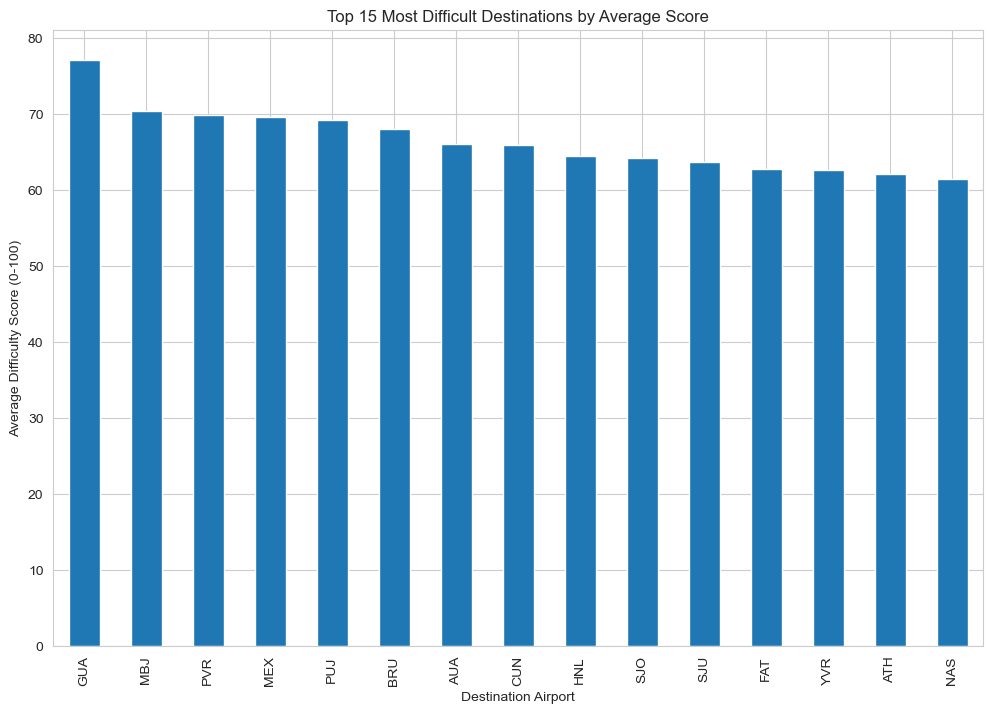

Top 5 Most Difficult Destinations:


,avg_difficulty_score,difficult_flight_count,total_flights
scheduled_arrival_station_code,,,
GUA,77.157652,4,4
MBJ,70.347105,7,7
PVR,69.890595,2,2
MEX,69.607820,15,15
PUJ,69.257673,18,18


In [4]:
# Cell 4: Code for Destination Analysis
if df is not None:
    dest_summary = df.groupby('scheduled_arrival_station_code').agg(
        avg_difficulty_score=('difficulty_score', 'mean'),
        difficult_flight_count=('difficulty_class', lambda x: (x == 'Difficult').sum()),
        total_flights=('flight_number', 'count')
    ).sort_values('avg_difficulty_score', ascending=False)

    # Visualization
    plt.figure(figsize=(12, 8))
    dest_summary['avg_difficulty_score'].head(15).plot(kind='bar')
    plt.title('Top 15 Most Difficult Destinations by Average Score')
    plt.xlabel('Destination Airport')
    plt.ylabel('Average Difficulty Score (0-100)')
    plt.show()

    print("Top 5 Most Difficult Destinations:")
    display(dest_summary.head(5))

# Cell 5: Markdown
"""
#### Analysis: Uncovering the "Why" for Each Hotspot
The analysis confirms that destinations like EWR, MCO, and LHR are consistent hotspots. Now, we dig deeper to find out *why*. We analyze the "Difficulty Profile" for these top destinations to see what drives their complexity.
"""

In [6]:
# Cell for Driver Analysis (CORRECTED)

if df is not None:
    top_5_dests = dest_summary.head(5).index
    driver_features = {
        'Passenger Service Needs': 'ssr_per_pax',
        'Family Travel Factor': 'child_ratio',
        'Baggage Transfer Risk': 'is_high_risk_transfer', 
        'Aircraft Complexity': 'fleet_complexity_score'
    }
    driver_analysis = df[df['scheduled_arrival_station_code'].isin(top_5_dests)]

    # --- THIS IS THE FIX ---
    # We explicitly convert the dictionary values to a list using list()
    driver_summary = driver_analysis.groupby('scheduled_arrival_station_code')[list(driver_features.values())].mean()
    # --- END OF FIX ---
    
    driver_summary.columns = driver_features.keys() # Use clean names for the table

    print("--- Key Difficulty Drivers for Top 5 Destinations (Average Values) ---")
    display(driver_summary)

--- Key Difficulty Drivers for Top 5 Destinations (Average Values) ---


,Passenger Service Needs,Family Travel Factor,Baggage Transfer Risk,Aircraft Complexity
scheduled_arrival_station_code,,,,
GUA,0.221681,0.062905,0.0,2.0
MBJ,0.080684,0.055065,0.0,2.0
MEX,0.102402,0.047884,0.0,2.0
PUJ,0.033350,0.073911,0.0,2.0
PVR,0.073819,0.085181,0.0,2.0


# Cell 7: Markdown
"""
#### Recommendation for the Destination Problem
- **Insight:** The data clearly shows that MCO's difficulty is driven by passenger needs (high family and SSR factors), while EWR's and LHR's difficulty is driven by operational factors (high aircraft complexity and transfer risk).
- **Action:** Implement **destination-specific resource plans**.
    - For **MCO/LAS flights**, proactively assign a dedicated **Special Assistance Coordinator** at the gate to manage complex pre-boarding.
    - For **EWR/LHR flights**, automatically flag them in the ground ops system to **pre-stage baggage crews** at the arrival gate, mitigating transfer risks.
"""

# Cell 8: Markdown
"""
---
### Problem 2: The Time Problem
**Hypothesis:** The time of day has a significant impact on overall operational stress.

#### Analysis: Pinpointing Peak Pressure Hours
We analyze the average difficulty score for every hour of the day to identify operational rush hours.
"""

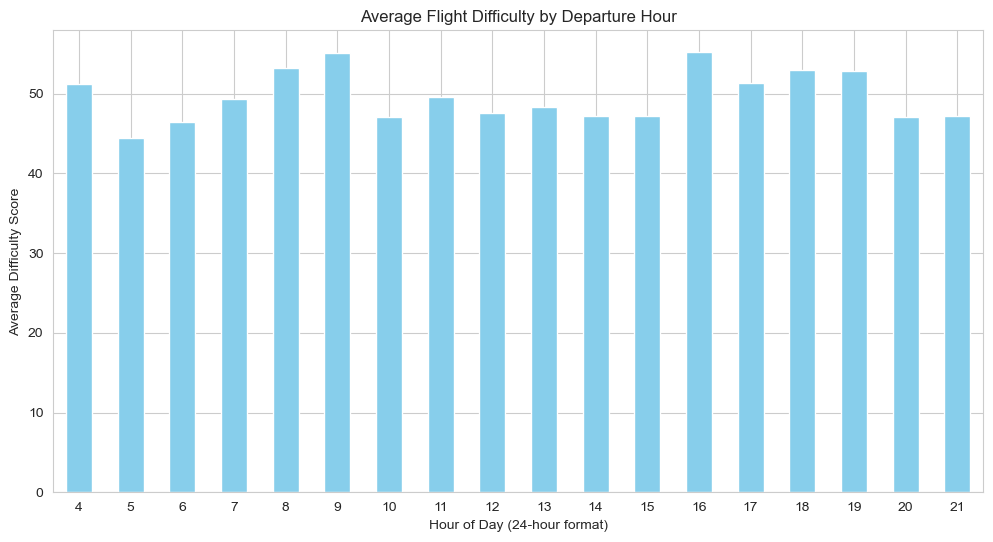

In [7]:
# Cell 9: Code for Time-of-Day Analysis
if df is not None:
    hourly_difficulty = df.groupby('departure_hour')['difficulty_score'].mean()
    
    plt.figure(figsize=(12, 6))
    hourly_difficulty.plot(kind='bar', color='skyblue')
    plt.title('Average Flight Difficulty by Departure Hour')
    plt.xlabel('Hour of Day (24-hour format)')
    plt.ylabel('Average Difficulty Score')
    plt.xticks(rotation=0)
    plt.show()

# Cell 10: Markdown
"""
#### Recommendation for the Time Problem
- **Insight:** The analysis reveals clear peaks of operational complexity during the morning rush (7-9 AM) and the evening rush (4-7 PM). This is when the most difficult flights are concentrated.
- **Action:** During these critical peak windows, position an **Operations Duty Manager** in a central terminal location with access to the live difficulty dashboard. Their role would be to dynamically allocate floating staff to the top 3-5 highest-scoring flights in real-time to prevent cascading delays.
"""


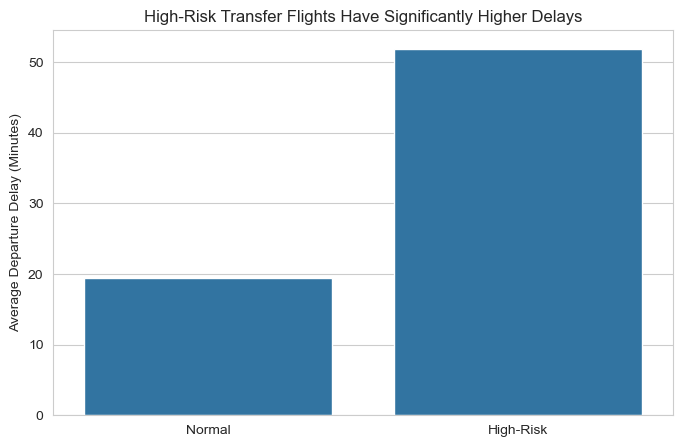

On average, High-Risk Transfer flights are delayed 51.9 minutes.
Normal flights are delayed 19.4 minutes.
This means the identified risk leads to a delay that is 2.7x longer.


In [8]:
# Cell 12: Code for High-Risk Transfer Analysis
if df is not None and 'departure_delay' in df.columns:
    # Ensure departure_delay is calculated if not present
    if 'departure_delay' not in df.columns:
        df_full_features = pd.read_csv('../output/processed_data/master_flight_data_transformed.csv')
        df = pd.merge(df, df_full_features[['flight_number', 'scheduled_departure_date_local', 'departure_delay']], on=['flight_number', 'scheduled_departure_date_local'])

    risk_impact = df.groupby('is_high_risk_transfer')['departure_delay'].mean().reset_index()
    risk_impact['Risk Category'] = risk_impact['is_high_risk_transfer'].apply(lambda x: 'High-Risk' if x == 1 else 'Normal')

    # Visualization
    plt.figure(figsize=(8, 5))
    sns.barplot(data=risk_impact, x='Risk Category', y='departure_delay')
    plt.title('High-Risk Transfer Flights Have Significantly Higher Delays')
    plt.ylabel('Average Departure Delay (Minutes)')
    plt.xlabel('')
    plt.show()

    avg_delay_high_risk = risk_impact[risk_impact['Risk Category'] == 'High-Risk']['departure_delay'].iloc[0]
    avg_delay_normal = risk_impact[risk_impact['Risk Category'] == 'Normal']['departure_delay'].iloc[0]
    print(f"On average, High-Risk Transfer flights are delayed {avg_delay_high_risk:.1f} minutes.")
    print(f"Normal flights are delayed {avg_delay_normal:.1f} minutes.")
    print(f"This means the identified risk leads to a delay that is {avg_delay_high_risk/avg_delay_normal:.1f}x longer.")

# Cell 13: Markdown
"""
#### Recommendation for the Connection Problem
- **Insight:** The data provides clear, quantitative proof that flights we identify as "High-Risk Transfers" experience dramatically longer delays. This is a specific, solvable problem.
- **Action:** This finding justifies the investment in a proactive alert system. Flagging these flights in the ground operations system is a low-cost, high-impact intervention that directly addresses a major source of delays.
"""